# Задание 1 Метод k-ближайших соседей (kNN) для задачи классификации изображений

Цель: написать классификатор kNN и использовать его на базе CIFAR-10.

Скачать базу изображений CIFAR-10 для задания можно по ссылке https://www.cs.toronto.edu/~kriz/cifar.html.

Этапы выполнения:

1. Обучить классификатор — выгрузить все данные в память;
2. Проверить классификатор — сравнить все тестовые изображения с изображениями из обучения и присвоить классы от k ближайших соседей;
3. Провести перекрестную проверку гиперпараметра k.

Ниже созданы ячейки для кода с комментариями, в которых указано, что необходимо сделать.

In [1]:
# coding: utf8 Для кодировки и отображения графиков в этом же "блокноте".

from __future__ import unicode_literals
%matplotlib inline

# Здесь же подключайте и другие требуемые библиотеки.
from sklearn.neighbors import KNeighborsClassifier
from keras.datasets import cifar10
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Необходимо загрузить изображения CIFAR-10 в память:
# изображения_обучение, классы_обучение, изображения_тест, классы_тест

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Для проверки корректности загрузки выведите размеры 4-х групп данных
x_train_red = x_train[:2000]
y_train_red = y_train[:2000]
x_test_red = x_test[:300]
y_test_red = y_test[:300]

x_train_red = x_train_red.reshape(x_train_red.shape[0],-1)
x_test_red = x_test_red.reshape(x_test_red.shape[0],-1)

#*** Ваш код ***
print(f'Размер данных обучающей выборки: {x_train_red.shape}')
print(f'Размер разметки обучающей выборки: {y_train_red.shape}')
print(f'Совпадает ли размер данных обучающей выборки с размером разметки обучающей выборки : \
{x_train_red.shape[0] == y_train_red.shape[0]}')
print(f'Размер данных тестовой выборки: {x_test_red.shape}')
print(f'Размер разметки тестовой выборки: {y_test_red.shape}')
print(f'Совпадает ли размер данных тестовой выборки с размером разметки тестовой выборки : \
{x_test_red.shape[0] == y_test_red.shape[0]}')

print(f'Всего изображений: {x_train_red.shape[0] + x_test_red.shape[0]}')

Размер данных обучающей выборки: (2000, 3072)
Размер разметки обучающей выборки: (2000, 1)
Совпадает ли размер данных обучающей выборки с размером разметки обучающей выборки : True
Размер данных тестовой выборки: (300, 3072)
Размер разметки тестовой выборки: (300, 1)
Совпадает ли размер данных тестовой выборки с размером разметки тестовой выборки : True
Всего изображений: 2300


In [3]:
#скалируем значения от 0 до 1
def norm_data(X):
    X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

#обработка y-ков в нужный формат списка
def procces_y_data(y):
    y_true = y
    y_ok =[]
    for i in range(len(y_true)):
        y_ok.append(y_true[i][0])
    return y_ok
    
x_train_red = norm_data(x_train_red)
x_test_red = norm_data(x_test_red)
y_test_red = procces_y_data(y_test_red)
y_train_red = procces_y_data(y_train_red)

In [4]:
# Теперь необходимо рассчитать расстояния между изображениями обучающей и тестовой выборок.
# Должна получится матрица расстояний размерностью (Nобуч x Nтест), где каждый элемент это расстояние между изображениями.
# Исходя из полученных расстояний, необходимо по k-соседям выбрать класс изображения.

#расчет l2-дистанций
def compute_distances(X_train, X_test):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        print(f'{i+1}/{num_test}', end ='\r')
        for j in range(num_train):
            dist = 0
            row1= X_train[j]
            row2 = X_test[i]
            for k in range(len(row1)-1):
                dist += (row1[k] - row2[k])**2
            dists[i, j] = np.sqrt(dist)
    return dists.T
 
class KNN:
    def __init__(self, X, y, X_test):
        self.X_train = X
        self.y_train = y
        self.X_test = X_test
        
    def fit(self):
        distances = compute_distances(self.X_test,self.X_train)
        return distances
                
    def predict(self, k , dists):
        predicted_labels = self._predict(k, dists)
        return np.array(predicted_labels)

    def _predict(self, k , dists):
        preds = []
        for i in range(len(self.X_test)):
            distances = dists[i]
            k_indices = np.argsort(distances)[:k] 
            k_labels = [self.y_train[j] for j in k_indices]
            majority_vote = Counter(k_labels).most_common(1)
            preds.append(majority_vote[0][0])
        return preds

In [380]:
# Теперь необходимо рассчитать расстояния между изображениями обучающей и тестовой выборок.
# Должна получится матрица расстояний размерностью (Nобуч x Nтест), где каждый элемент это расстояние между изображениями.
# Исходя из полученных расстояний, необходимо по k-соседям выбрать класс изображения.
net = KNN(x_train_red, y_train_red, x_test_red)
dists = net.fit()

In [387]:
# Отобразите точность работы классификатора (количество правильных классов) для случая k=1.
# Она должна оказаться около 27%.
predictions = net.predict(1, dists)
acc =  np.sum(predictions == y_test_red) / len(y_test_red)
print(f'результирующая точность для (k = 1) = {np.round(acc*100,4)} %')

результирующая точность для (k = 1) = 23.6667 %


In [386]:
# Теперь для случая k=5.
predictions = net.predict(5 , dists)
    
acc =  np.sum(predictions == y_test_red) / len(y_test_red)
print(f'результирующая точность для (k = 5) = {np.round(acc*100,4)} %')

результирующая точность для (k = 5) = 25.6667 %


### Перекрестная проверка

Ранее вы попробовали значения k=1 и k=5. Теперь необходимо выбрать лучшее значение этого гиперпараметра при помощи перекрестной проверки.

In [388]:
# Разбейте базу на 5 подвыборок.
# И рассчитайте точность для k 1, 3, 5, 8, 10, 12, 15, 20, 50, 100.
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(x_train_red, num_folds)

y_train_folds = np.array_split(y_train_red, num_folds)

k_to_accuracies = {}
for k in k_choices:
    k_to_accuracies[k] = []
    
dist_folds = {}
for i in range(num_folds):
    dist_folds[i+1] = []
    
#расчет дистанций для каждой подвыборки
for j in range(num_folds):
    print('num fold=%d' % j+1)
    X_train_crossval = np.vstack(X_train_folds[0:j] + X_train_folds[j+1:])
    X_test_crossval = X_train_folds[j]
    y_train_crossval = np.hstack(y_train_folds[0:j]+y_train_folds[j+1:])
    y_test_crossval = y_train_folds[j]
    net = KNN(X_train_crossval, y_train_crossval, X_test_crossval)
    dists = net.fit()
    dist_folds[j+1].append(dists)
    print()

#предсказание значений
for k in k_choices:
    print('k=%d' % k)
    acc = []
    for j in range(num_folds):
        # Use all but one folds as our crossval training set
        X_train_crossval = np.vstack(X_train_folds[0:j] + X_train_folds[j+1:])
        # Use the last fold as our crossval test set
        X_test_crossval = X_train_folds[j]
        y_train_crossval = np.hstack(y_train_folds[0:j]+y_train_folds[j+1:])
        y_test_crossval = y_train_folds[j]
        net = KNN(X_train_crossval, y_train_crossval, X_test_crossval)
        dists = dist_folds[j+1][0]
        y_test_pred = predictions = net.predict(k , dists)
        num_correct = np.sum(y_test_pred == y_test_crossval)
        accuracy = float(num_correct) / len(y_test_crossval)
        acc.append(accuracy)
    k_to_accuracies[k].append(np.array(acc).mean())

num fold=0
1600/1600
num fold=1
1600/1600
num fold=2
1600/1600
num fold=3
1600/1600
num fold=4
1600/1600
k=1
k=3
k=5
k=8
k=10
k=12
k=15
k=20
k=50
k=100


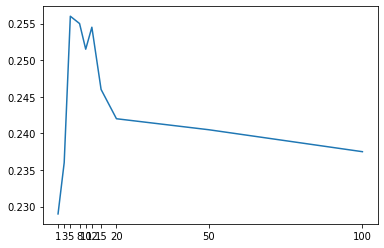

In [389]:
# Постройте график точности от количества соседей k.
x = list(k_to_accuracies.keys())
y = list(k_to_accuracies.values())
plt.plot(x,y)
plt.xticks(x)
plt.show()

In [5]:
# Основываясь на полученном k обучите модель на всех данных. Точность на тестовой воборке должна превысить 28%.
net = KNN(x_train_red, y_train_red, x_test_red)
dists = net.fit()
y_test_pred = predictions = net.predict(3 , dists)
num_correct = np.sum(y_test_pred == y_test_red)
accuracy = float(num_correct) / len(y_test_red)
print()
print(f'результирующая точность для лучшего гиперпараметра {np.round(accuracy*100,4)} %')

2000/2000
результирующая точность для лучшего гиперпараметра 27.0 %
